TIME SERIES FORCASTING (LET'S TRY TO UNDERSTANF THIS!)

In [10]:
#importing necessary libraries( been installed before)
import yfinance as yf 
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pylab import rcParams
from prophet import Prophet


In [11]:
# using y finance to fetch data (here I have fetched apple data from 2010) and than converted it into dataframe
aapl_data = yf.download('AAPL', start='2010-01-01', end='2024-04-17') 
data = pd.DataFrame(aapl_data)

[*********************100%%**********************]  1 of 1 completed


In [12]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.470742,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.481929,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.378825,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.367034,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.409362,447610800
...,...,...,...,...,...,...
2024-04-10,168.800003,169.089996,167.110001,167.779999,167.779999,49709300
2024-04-11,168.339996,175.460007,168.160004,175.039993,175.039993,91070300
2024-04-12,174.259995,178.360001,174.210007,176.550003,176.550003,101593300


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3595 entries, 2010-01-04 to 2024-04-16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3595 non-null   float64
 1   High       3595 non-null   float64
 2   Low        3595 non-null   float64
 3   Close      3595 non-null   float64
 4   Adj Close  3595 non-null   float64
 5   Volume     3595 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 196.6 KB


In [14]:
#Dropping the unwanted columns and adding a date column
data.drop(axis=1,labels=['Open','High','Low','Adj Close','Volume'],inplace=True)
data['Timestamp']=data.index

In [15]:
data

,Close,Timestamp
Date,,
2010-01-04,7.643214,2010-01-04
2010-01-05,7.656429,2010-01-05
2010-01-06,7.534643,2010-01-06
2010-01-07,7.520714,2010-01-07
2010-01-08,7.570714,2010-01-08
...,...,...
2024-04-10,167.779999,2024-04-10
2024-04-11,175.039993,2024-04-11
2024-04-12,176.550003,2024-04-12


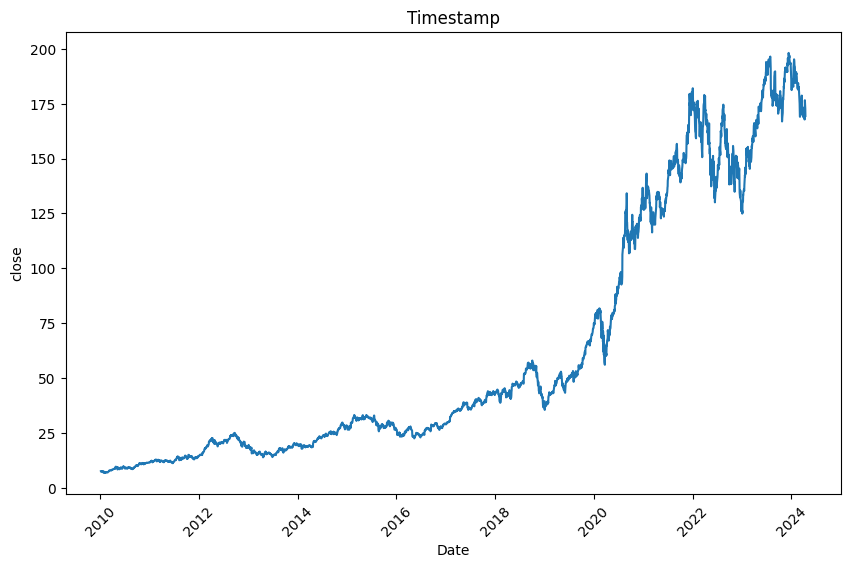

In [16]:
#vizualizing the data
plt.figure(figsize=(10, 6)) 
plt.plot(data['Timestamp'], data['Close']) 
plt.xlabel('Date') 
plt.ylabel('close') 
plt.title('Timestamp') 
plt.xticks(rotation=45) 
plt.show()

In [17]:
#Running the ADF (augmented Dickey–Fuller) and KPSS (Kwiatkowski–Phillips–Schmidt–Shin) tests to check the stationarity
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')    
    print('ADF Statistic: {:.4f}'.format(result[0]))    
    print('p-value: {:.4f}'.format(result[1]))    
    print('Critical Values:')    
    for key, value in result[4].items():        
        print('\t{}: {:.4f}'.format(key, value))
        
def kpss_test (timeseries):
    result = kpss(timeseries, regression='c', nlags='auto')    
    print('\nKPSS Statistic: {:.4f}'.format(result[0]))    
    print('p-value: {:.4f}'.format(result[1]))    
    print('Critical Values:')    
    for key, value in result[3].items():        
        print('\t{}: {:.4f}'.format(key, value))
        
print('\nResults of KPSS Test:') 
kpss_test(data['Close'])
    
print('\nResults of Augmented Dickey-Fuller Test:\n') 
adf_test(data['Close'])

C:\Users\dkhemka\AppData\Local\Temp\ipykernel_31436\1755613339.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(timeseries, regression='c', nlags='auto')



Results of KPSS Test:

KPSS Statistic: 7.7271
p-value: 0.0100
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390

Results of Augmented Dickey-Fuller Test:

ADF Statistic: 0.1351
p-value: 0.9684
Critical Values:
	1%: -3.4322
	5%: -2.8624
	10%: -2.5672


Inference- The data is not stationary according to both tests. The KPSS test rejects stationarity (indicating the presence of a unit root or a trend), and the ADF test fails to reject the presence of a unit root.

In [18]:
# Differencing
data['stationary_series'] = data['Close'].diff()
data.dropna(inplace=True)
print(data.head())

# data.to_csv('empty_5.csv')

               Close  Timestamp  stationary_series
Date                                              
2010-01-05  7.656429 2010-01-05           0.013215
2010-01-06  7.534643 2010-01-06          -0.121786
2010-01-07  7.520714 2010-01-07          -0.013929
2010-01-08  7.570714 2010-01-08           0.050000
2010-01-11  7.503929 2010-01-11          -0.066785


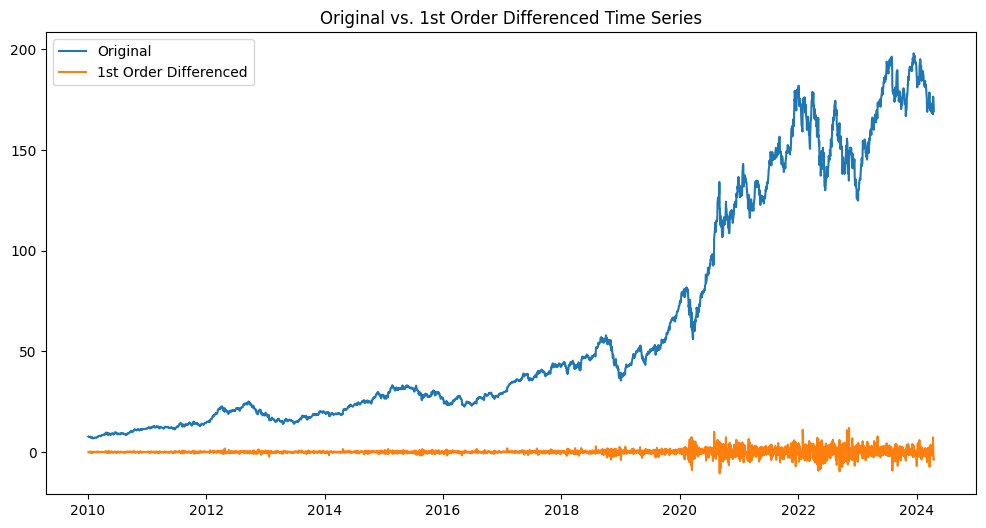

In [19]:
#plotting original vs first order diffferencing
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Original')
plt.plot(data['stationary_series'], label='1st Order Differenced')
plt.title('Original vs. 1st Order Differenced Time Series')
plt.legend()
plt.show()

In [20]:
# Again running ADF and KPSS test
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')    
    print('ADF Statistic: {:.4f}'.format(result[0]))    
    print('p-value: {:.4f}'.format(result[1]))    
    print('Critical Values:')    
    for key, value in result[4].items():        
        print('\t{}: {:.4f}'.format(key, value))
        
def kpss_test (timeseries):
    result = kpss(timeseries, regression='c', nlags='auto')    
    print('\nKPSS Statistic: {:.4f}'.format(result[0]))    
    print('p-value: {:.4f}'.format(result[1]))    
    print('Critical Values:')    
    for key, value in result[3].items():        
        print('\t{}: {:.4f}'.format(key, value))
print('\nResults of KPSS Test:') 
kpss_test(data['stationary_series'])
    
print('\nResults of Augmented Dickey-Fuller Test:\n') 
adf_test(data['stationary_series'])


Results of KPSS Test:

KPSS Statistic: 0.1887
p-value: 0.1000
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390

Results of Augmented Dickey-Fuller Test:

ADF Statistic: -11.0447
p-value: 0.0000
Critical Values:
	1%: -3.4322
	5%: -2.8624
	10%: -2.5672


C:\Users\dkhemka\AppData\Local\Temp\ipykernel_31436\3666854803.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(timeseries, regression='c', nlags='auto')


Inference- the data is likely, as indicated by both the KPSS and ADF tests

In [21]:
# converting data to numeric
data=data.apply(pd.to_numeric)

In [22]:
data.info

<bound method DataFrame.info of                  Close            Timestamp  stationary_series
Date                                                          
2010-01-05    7.656429  1262649600000000000           0.013215
2010-01-06    7.534643  1262736000000000000          -0.121786
2010-01-07    7.520714  1262822400000000000          -0.013929
2010-01-08    7.570714  1262908800000000000           0.050000
2010-01-11    7.503929  1263168000000000000          -0.066785
...                ...                  ...                ...
2024-04-10  167.779999  1712707200000000000          -1.889999
2024-04-11  175.039993  1712793600000000000           7.259995
2024-04-12  176.550003  1712880000000000000           1.510010
2024-04-15  172.690002  1713139200000000000          -3.860001
2024-04-16  169.380005  1713225600000000000          -3.309998

[3594 rows x 3 columns]>

In [23]:
data['Timestamp']=data.index

In [24]:
data

,Close,Timestamp,stationary_series
Date,,,
2010-01-05,7.656429,2010-01-05,0.013215
2010-01-06,7.534643,2010-01-06,-0.121786
2010-01-07,7.520714,2010-01-07,-0.013929
2010-01-08,7.570714,2010-01-08,0.050000
2010-01-11,7.503929,2010-01-11,-0.066785
...,...,...,...
2024-04-10,167.779999,2024-04-10,-1.889999
2024-04-11,175.039993,2024-04-11,7.259995
2024-04-12,176.550003,2024-04-12,1.510010


In [25]:
monthly_mean=data['Close'].resample('M').mean()

C:\Users\dkhemka\AppData\Local\Temp\ipykernel_31436\341997677.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_mean=data['Close'].resample('M').mean()


In [26]:
monthly_data=monthly_mean.to_frame()
monthly_data

,Close
Date,
2010-01-31,7.405913
2010-02-28,7.099850
2010-03-31,7.978960
2010-04-30,8.969592
2010-05-31,8.980768
...,...
2023-12-31,194.308501
2024-01-31,187.724284
2024-02-29,184.775500


<Figure size 2000x1600 with 0 Axes>

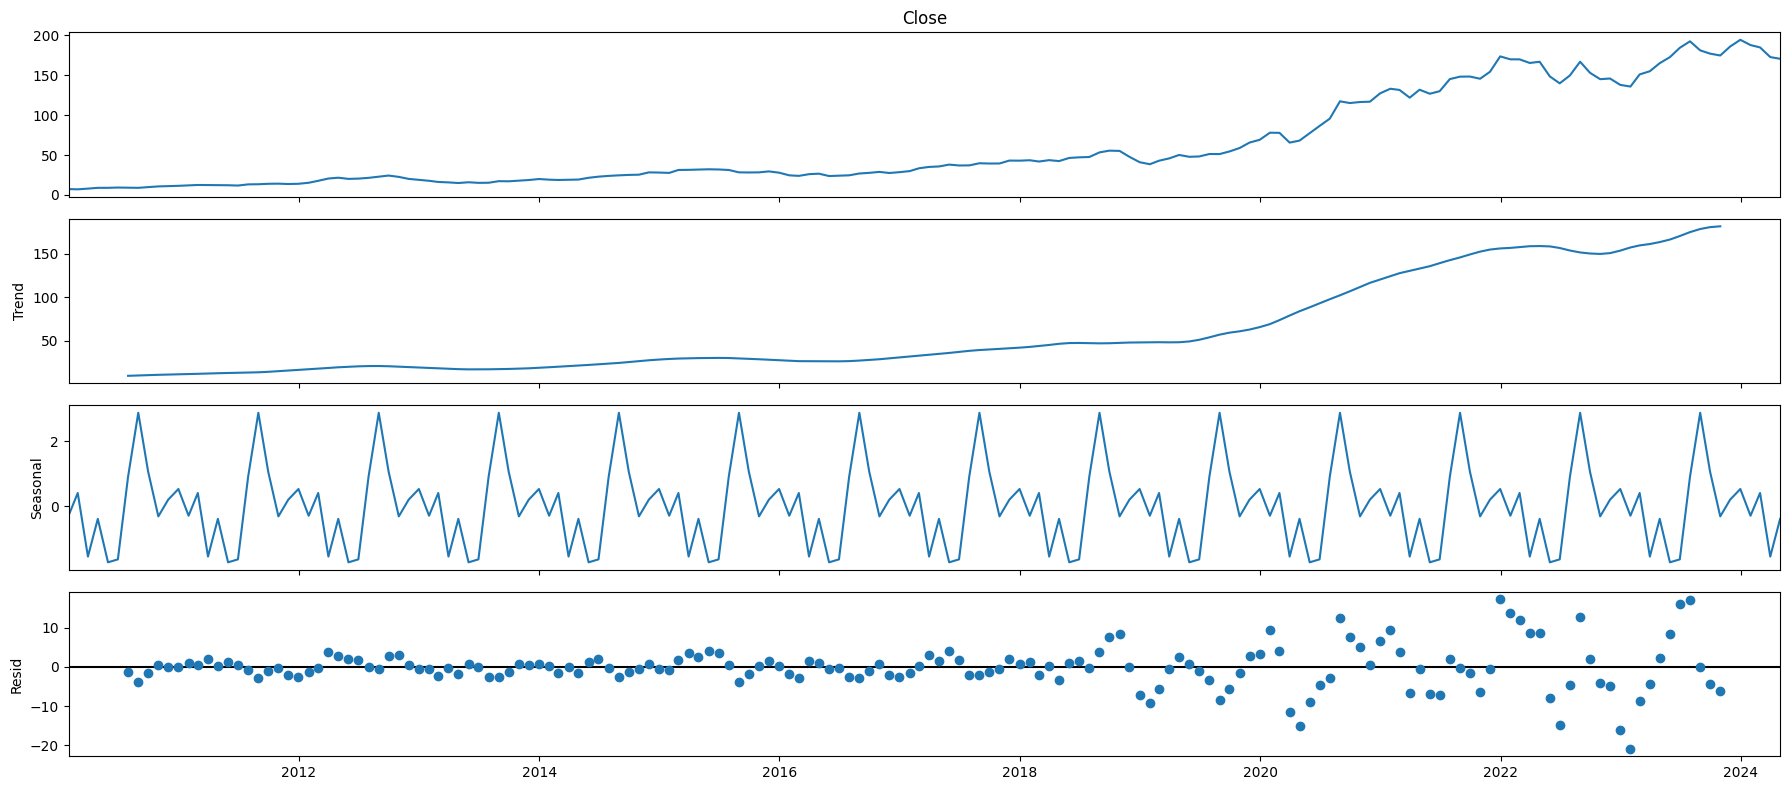

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose as sd

rcParams['figure.figsize'] =18,8
plt.figure(figsize=(20,16)) 
decomposed_series = sd(monthly_data['Close'],model='additive') 
decomposed_series.plot() 
plt.show()

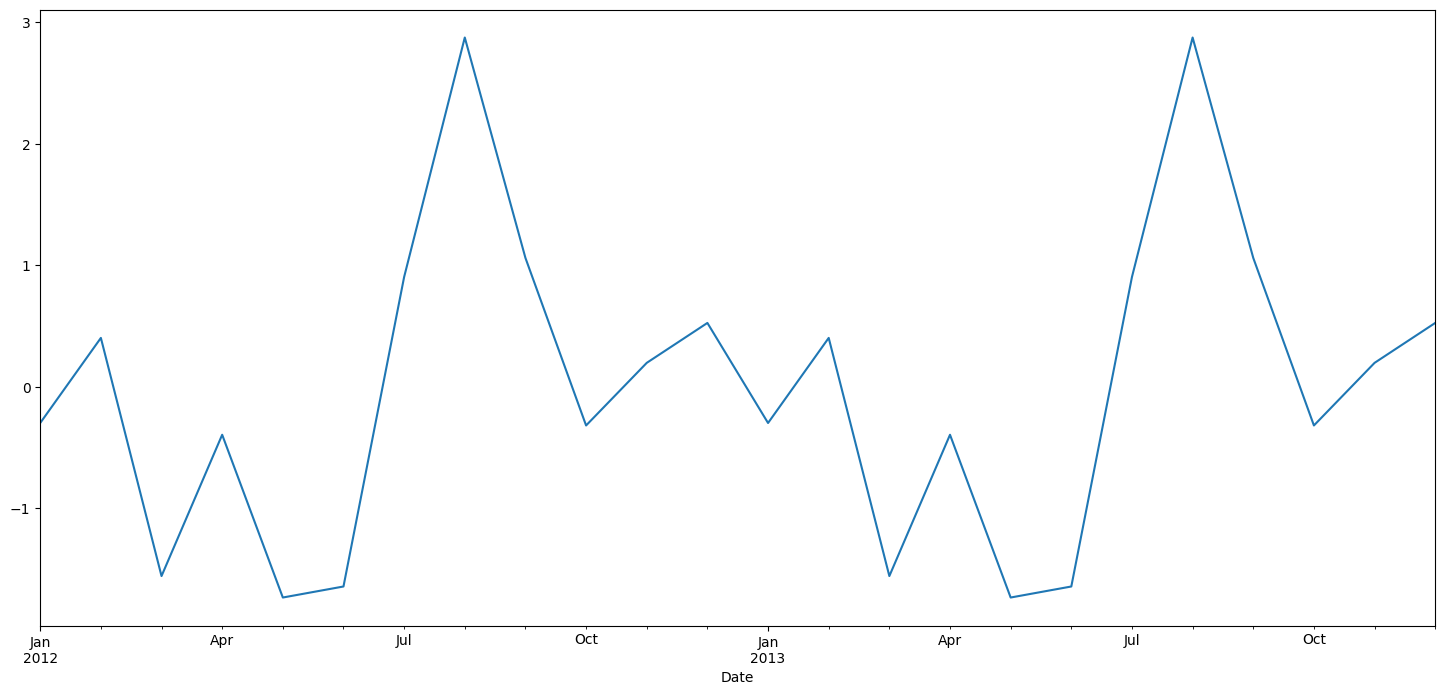

<Figure size 800x800 with 0 Axes>

In [28]:
decomposed_series.seasonal['2012':'2013'].plot()
fig=plt.figure(figsize=(8,8))


Text(0.5, 0, 'Lags')

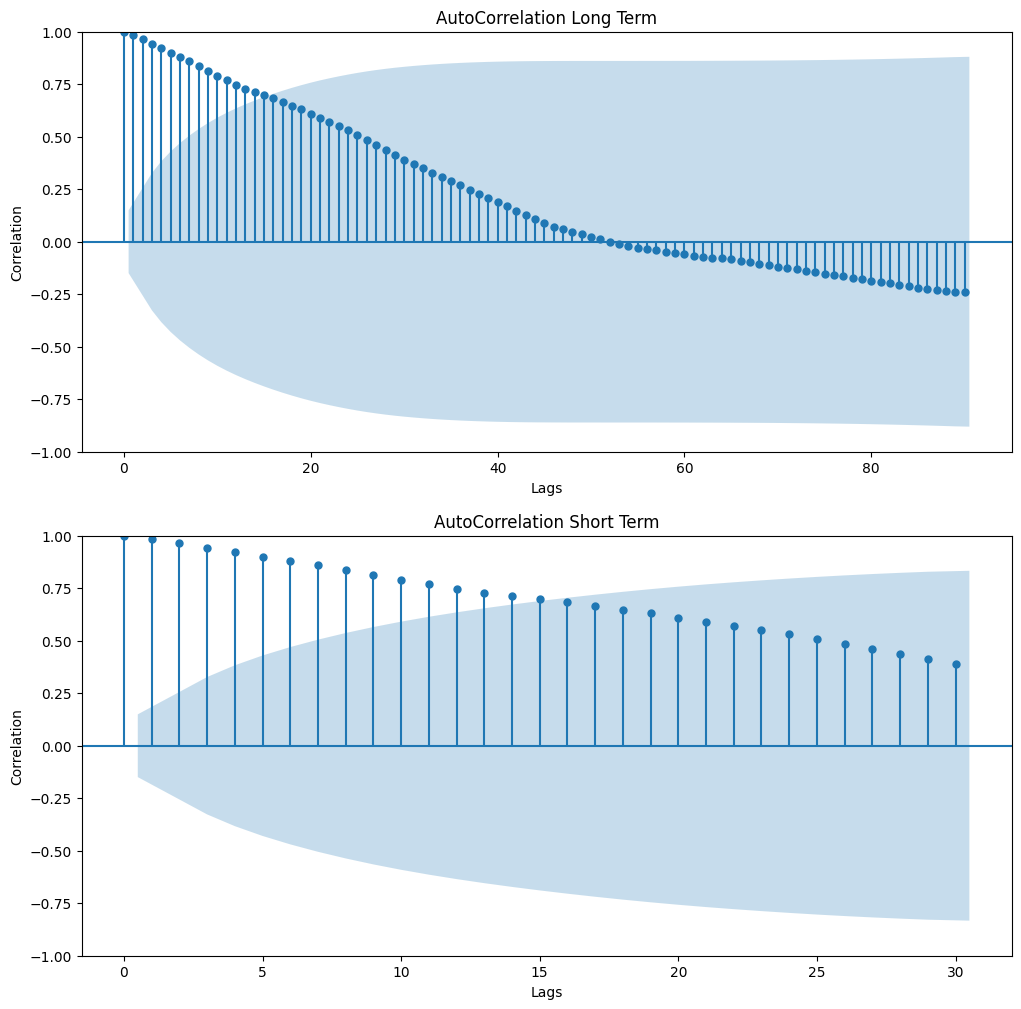

In [29]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(12,12)) 
acf = plot_acf(monthly_data['Close'],lags=90,ax=ax1) 
ax1.set_title('AutoCorrelation Long Term') 
acf = plot_acf(monthly_data['Close'],lags=30,ax=ax2) 
ax2.set_title('AutoCorrelation Short Term') 
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags') 
ax2.set_ylabel('Correlation') 
ax2.set_xlabel('Lags')

Interpreting ACF Plot :-
->Slow Decay of correlation values indicates that the future values are heavily dependent on the lagged values . This shows that the series is not random and good for time series modelling .
->Also tells us series is Non-stationary
->It indicates a MA(1) process

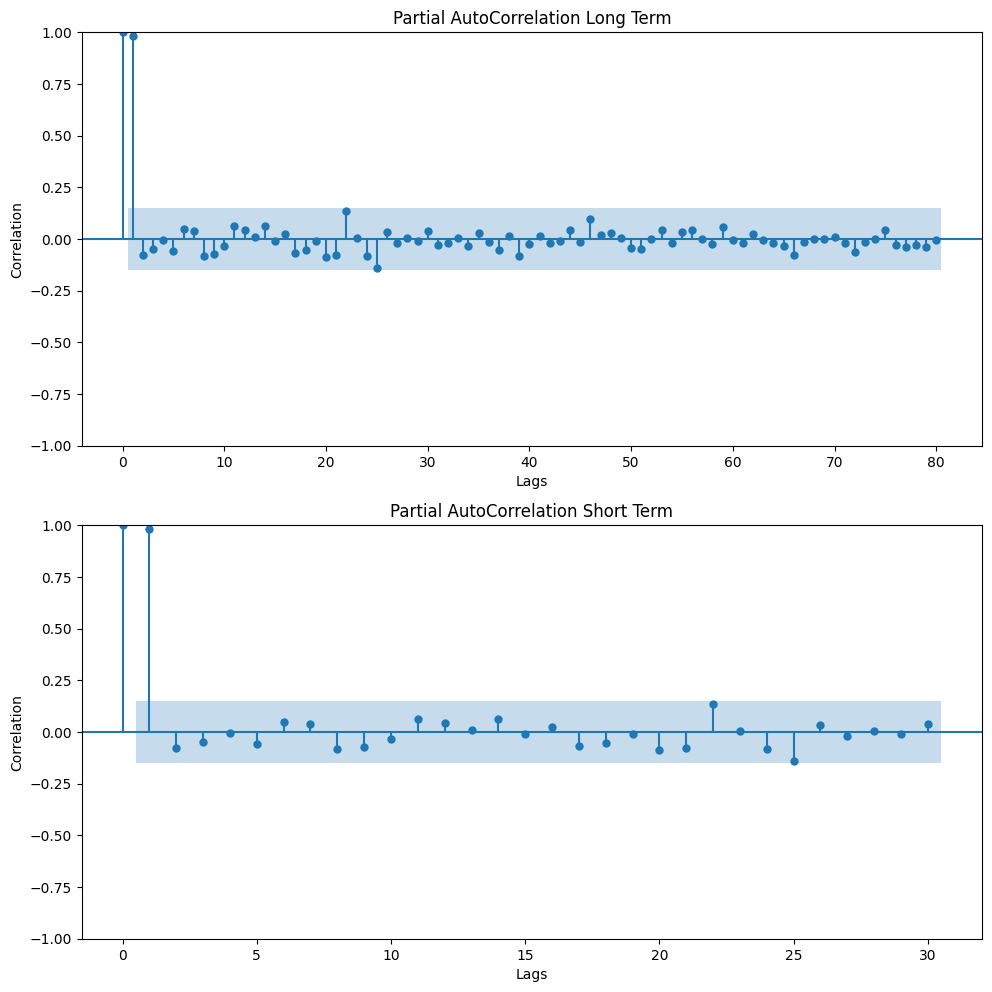

In [30]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(10,10)) 
pacf = plot_pacf(monthly_data['Close'],lags=80,ax=ax1) 
ax1.set_title('Partial AutoCorrelation Long Term') 
pacf = plot_pacf(monthly_data['Close'],lags=30,ax=ax2) 
ax2.set_title('Partial AutoCorrelation Short Term') 
ax1.set_ylabel('Correlation') 
ax1.set_xlabel('Lags') 
ax2.set_ylabel('Correlation') 
ax2.set_xlabel('Lags') 
plt.tight_layout(pad=1)

Interpretation- sudden decay at lag1, AR(1)

In [31]:
train_size = int(len(data) * 0.80)  
train_data = data.iloc[:train_size]
valid_data = data.iloc[train_size:]

In [32]:
train_data

,Close,Timestamp,stationary_series
Date,,,
2010-01-05,7.656429,2010-01-05,0.013215
2010-01-06,7.534643,2010-01-06,-0.121786
2010-01-07,7.520714,2010-01-07,-0.013929
2010-01-08,7.570714,2010-01-08,0.050000
2010-01-11,7.503929,2010-01-11,-0.066785
...,...,...,...
2021-06-01,124.279999,2021-06-01,-0.330002
2021-06-02,125.059998,2021-06-02,0.779999
2021-06-03,123.540001,2021-06-03,-1.519997


c:\Users\dkhemka\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dkhemka\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dkhemka\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


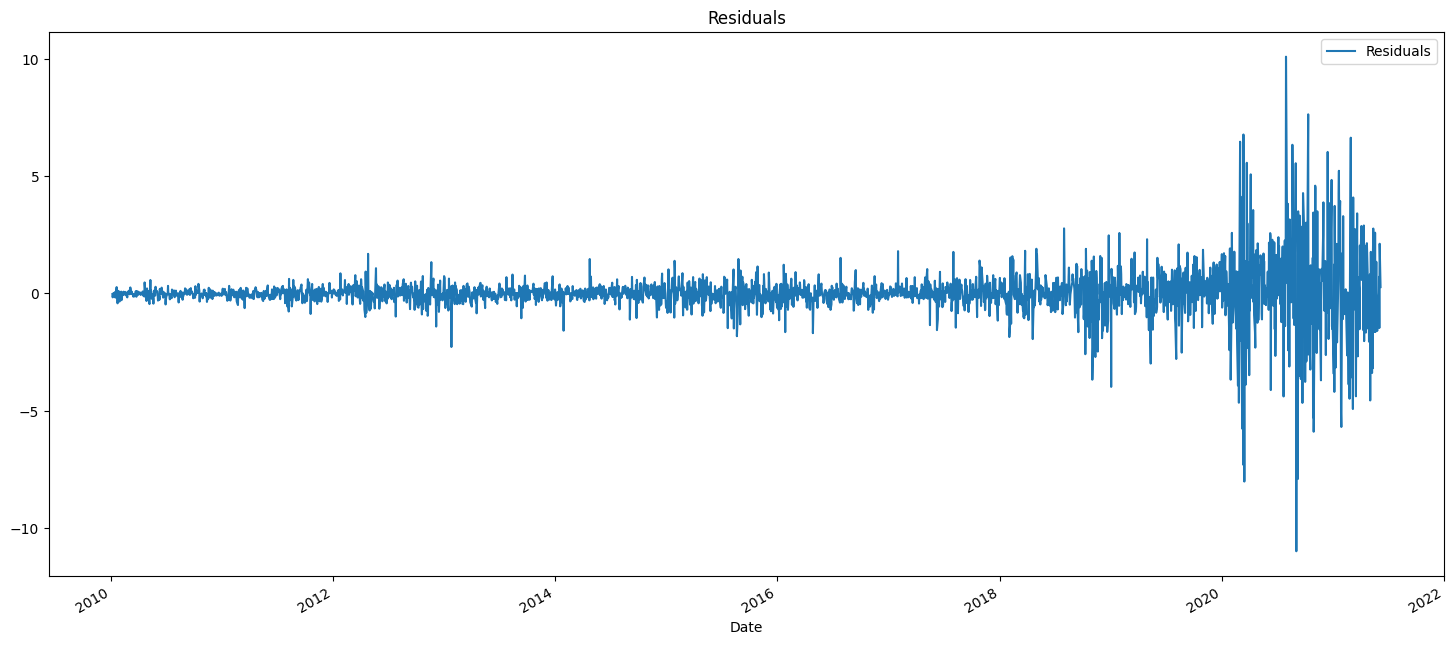

In [33]:
column_name_diff = 'stationary_series'

p = 1  
d = 0
q = 1  

model = ARIMA(train_data[column_name_diff], order=(p, d, q))
fitted_model = model.fit()

# print(fitted_model.summary())
 
# Plot residuals to assess model fit
residuals = pd.DataFrame(fitted_model.resid, columns=['Residuals'])
residuals.plot(title="Residuals")
plt.show()

In [34]:
# fitted_model.plot_diagnostics(figsize=(12,8))
# plt.show()

In [35]:
# Specify number of periods to forecast
forecast_periods = len(valid_data)  # Example: forecast 10 periods into the future
 
# Make forecasts
forecast_values = fitted_model.forecast(steps=forecast_periods)
 
# Print forecasted values
print("Forecasted Values:")
print(forecast_values)
 
# Optionally, plot the forecasted values
# plt.figure(figsize=(12, 6))
# plt.plot(data[column_name_diff], label='Original (Differenced)')
# plt.plot(range(len(train_data[column_name_diff]), len(train_data[column_name_diff]) + forecast_periods), forecast_values, label='Forecast')
# plt.title('ARIMA Forecast')
# plt.legend()
# plt.show()

Forecasted Values:
2875    0.123786
2876    0.010427
2877    0.052544
2878    0.036896
2879    0.042710
          ...   
3589    0.041135
3590    0.041135
3591    0.041135
3592    0.041135
3593    0.041135
Name: predicted_mean, Length: 719, dtype: float64


c:\Users\dkhemka\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\dkhemka\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [36]:
# Retrieve the last known value of the original time series
last_observed_value = train_data['Close'].iloc[-1]
 
# Calculate cumulative sum of forecasted differenced values to reverse the differencing
forecasted_values_original_scale = np.cumsum(forecast_values) + last_observed_value
predicted_df = pd.DataFrame(list(forecasted_values_original_scale))


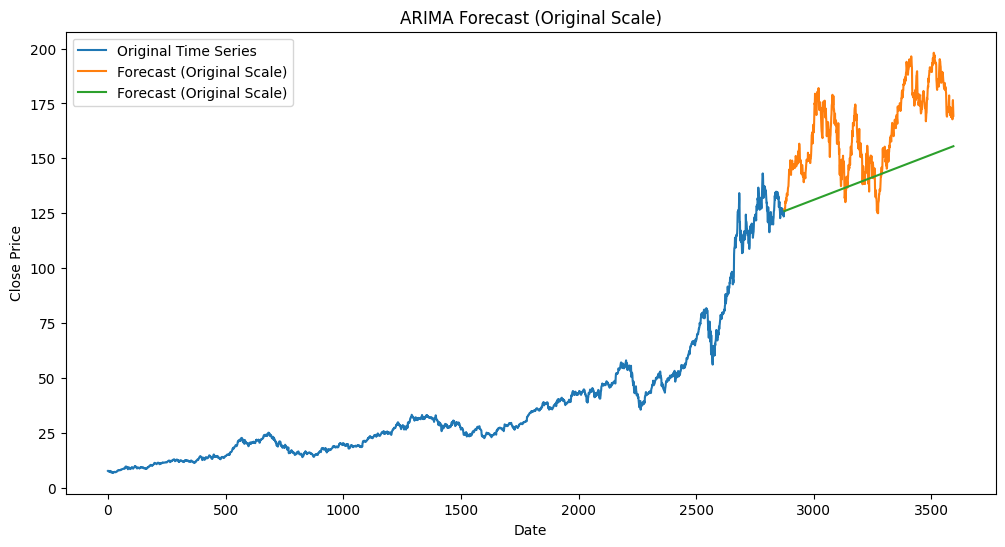

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot the original dataframe
plt.plot([i for i in range(len(train_data))],train_data['Close'], label='Original Time Series')
plt.plot([i+len(train_data) for i in range(len(valid_data))],valid_data['Close'], label='Forecast (Original Scale)')
# Plot the forecasted dataframe
plt.plot([i+len(train_data) for i in range(len(valid_data))],predicted_df[0], label='Forecast (Original Scale)')

plt.title('ARIMA Forecast (Original Scale)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

c:\Users\dkhemka\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dkhemka\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dkhemka\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\dkhemka\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available.

2875    0.119653
2876    0.126099
2877    0.048882
2878    0.081751
2879    0.168570
          ...   
3589    0.098450
3590    0.098450
3591    0.098450
3592    0.098450
3593    0.098450
Name: predicted_mean, Length: 719, dtype: float64


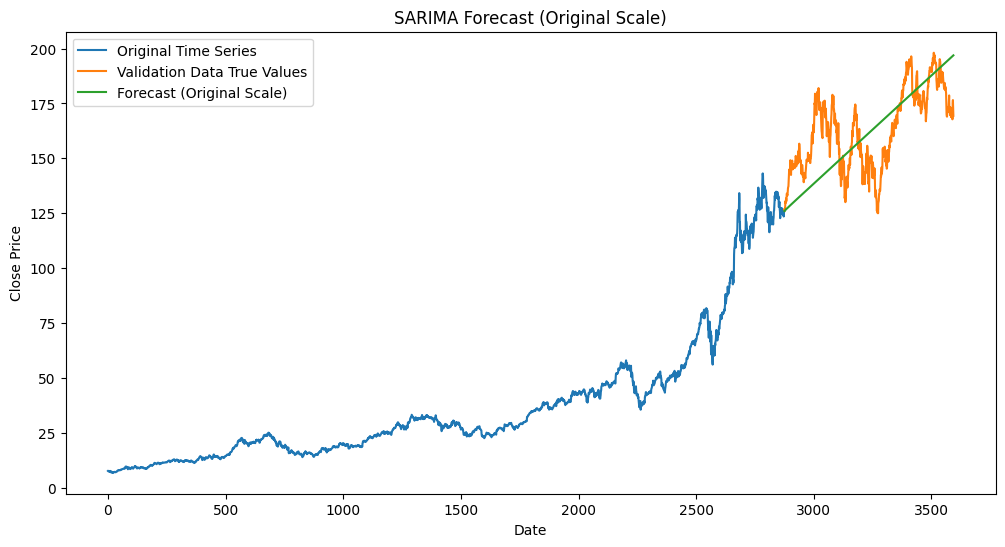

In [38]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

column_name_diff = 'stationary_series'

p = 1 
d = 1  
q = 1  

s = 12 

# Seasonal
P = 1 
D = 0 
Q = 1 

# Create and fit SARIMA model
SARIMA_model = SARIMAX(train_data[column_name_diff], order=(p, d, q), seasonal_order=(P, D, Q, s))
SARIMA_fitted_model = SARIMA_model.fit()

# Plot residuals to assess model fit
residuals = pd.DataFrame(SARIMA_fitted_model.resid, columns=['Residuals'])

# Specify number of periods to forecast
forecast_periods = len(valid_data)  
 
# Make forecasts
forecast_values = SARIMA_fitted_model.forecast(steps=forecast_periods)
 
# Retrieve the last known value of the original time series
last_observed_value = train_data['Close'].iloc[-1]
print(forecast_values)
# Calculate cumulative sum of forecasted differenced values to reverse the differencing
forecasted_values_original_scale = np.cumsum(forecast_values) + last_observed_value
predicted_df_sarima = pd.DataFrame(list(forecasted_values_original_scale))
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot the original dataframe
plt.plot([i for i in range(len(train_data))],train_data['Close'], label='Original Time Series')
plt.plot([i+len(train_data) for i in range(len(valid_data))],valid_data['Close'], label='Validation Data True Values')
# Plot the forecasted dataframe
plt.plot([i+len(train_data) for i in range(len(valid_data))],predicted_df_sarima[0], label='Forecast (Original Scale)')

plt.title('SARIMA Forecast (Original Scale)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [39]:
train_data['Date'] = list(train_data.index)

C:\Users\dkhemka\AppData\Local\Temp\ipykernel_31436\1145143972.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Date'] = list(train_data.index)


C:\Users\dkhemka\AppData\Local\Temp\ipykernel_31436\2879235803.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.rename(columns={'Date': 'ds', 'stationary_series': 'y'}, inplace=True)
15:46:05 - cmdstanpy - INFO - Chain [1] start processing
15:46:06 - cmdstanpy - INFO - Chain [1] done processing


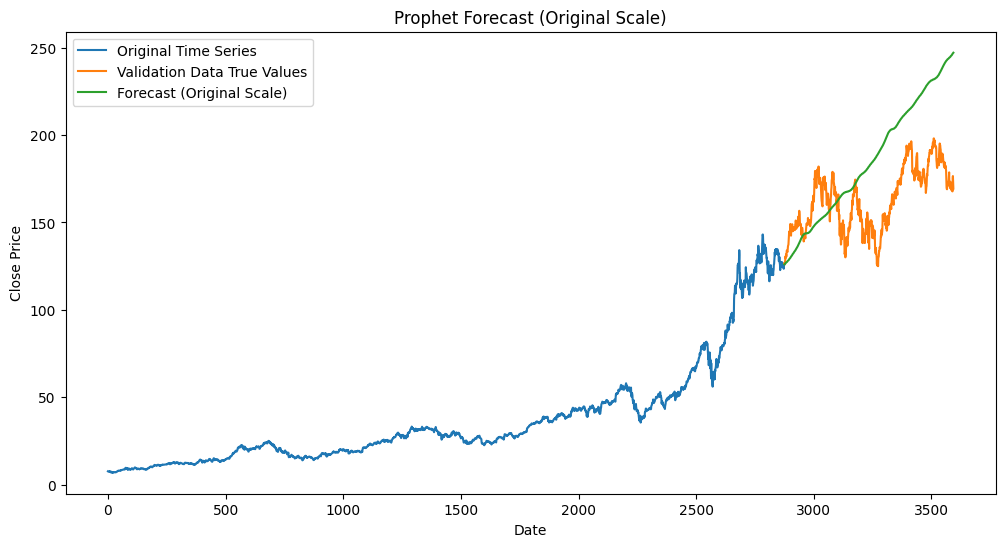

In [40]:
column_name_diff = 'stationary_series'

train_data.rename(columns={'Date': 'ds', 'stationary_series': 'y'}, inplace=True)

# Instantiate Prophet model
model = Prophet()
model.fit(train_data)
future = model.make_future_dataframe(periods=len(valid_data))
forecast_values = model.predict(future)
last_observed_value = train_data['Close'].iloc[-1]
 
# Calculate cumulative sum of forecasted differenced values to reverse the differencing
forecasted_values_original_scale = np.cumsum(forecast_values['yhat'][-719:]) + last_observed_value
predicted_df_prophet = pd.DataFrame(list(forecasted_values_original_scale))
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot the original dataframe
plt.plot([i for i in range(len(train_data))],train_data['Close'], label='Original Time Series')
plt.plot([i+len(train_data) for i in range(len(valid_data))],valid_data['Close'], label='Validation Data True Values')
# Plot the forecasted dataframe
plt.plot([i+len(train_data) for i in range(len(valid_data))],predicted_df_prophet[0], label='Forecast (Original Scale)')

plt.title('Prophet Forecast (Original Scale)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [53]:
df=pd.DataFrame()
actual=valid_data['Close']
df['Actual']=actual
df['Predicted_sarima']=list(predicted_df_sarima[0])
df['Predicted_arima']=list(predicted_df[0])
df['Predicted_prophet']=list(predicted_df_prophet[0])

df

,Actual,Predicted_sarima,Predicted_arima,Predicted_prophet
Date,,,,
2021-06-08,126.739998,126.019654,126.023788,126.059774
2021-06-09,127.129997,126.145753,126.034215,126.222130
2021-06-10,126.110001,126.194635,126.086758,126.308141
2021-06-11,127.349998,126.276386,126.123654,126.378309
2021-06-14,130.479996,126.444956,126.166364,126.520031
...,...,...,...,...
2024-04-10,167.779999,196.519765,155.371582,246.400408
2024-04-11,175.039993,196.618214,155.412716,246.612812
2024-04-12,176.550003,196.716664,155.453851,246.756318


In [54]:
df['accuracy_sarima'] = ((1-abs(df['Actual'] - df['Predicted_sarima'])/ df['Actual'])*100).round(2).astype(str) + '%'
df['accuracy_arima'] = ((1-abs(df['Actual'] - df['Predicted_arima'])/ df['Actual'])*100).round(2).astype(str) + '%'
df['accuracy_prophet'] = ((1-abs(df['Actual'] - df['Predicted_prophet'])/ df['Actual'])*100).round(2).astype(str) + '%'
df.head()

,Actual,Predicted_sarima,Predicted_arima,Predicted_prophet,accuracy_sarima,accuracy_arima,accuracy_prophet
Date,,,,,,,
2021-06-08,126.739998,126.019654,126.023788,126.059774,99.43%,99.43%,99.46%
2021-06-09,127.129997,126.145753,126.034215,126.222130,99.23%,99.14%,99.29%
2021-06-10,126.110001,126.194635,126.086758,126.308141,99.93%,99.98%,99.84%
2021-06-11,127.349998,126.276386,126.123654,126.378309,99.16%,99.04%,99.24%
2021-06-14,130.479996,126.444956,126.166364,126.520031,96.91%,96.69%,96.97%


In [57]:
from sklearn.metrics import mean_squared_error
import numpy as np
 
# Assuming 'actual_column' and 'predicted_column' are columns in your DataFrame containing the actual and predicted values respectively
 
# Calculate Mean Squared Error (MSE)
mse1 = mean_squared_error(df['Actual'], df['Predicted_arima'])
mse2 = mean_squared_error(df['Actual'], df['Predicted_sarima']) 
mse3 = mean_squared_error(df['Actual'], df['Predicted_prophet']) 
# Calculate Root Mean Squared Error (RMSE)
rmse1 = np.sqrt(mse1)
rmse2 = np.sqrt(mse2)
rmse3 = np.sqrt(mse3)

Accuracy_arima = df['accuracy_arima'].str.rstrip('%').astype(float).mean()
Accuracy_sarima = df['accuracy_sarima'].str.rstrip('%').astype(float).mean()
Accuracy_prophet = df['accuracy_prophet'].str.rstrip('%').astype(float).mean()

print("ARIMA\nMean Squared Error (MSE):", mse1)
print("Root Mean Squared Error (RMSE):", rmse1)
print("Accuracy Arima:", Accuracy_arima)

print("\nSARIMA\nMean Squared Error (MSE):", mse2)
print("Root Mean Squared Error (RMSE):", rmse2)
print("Accuracy Sarima:", Accuracy_sarima)

print("\nPROPHET\nMean Squared Error (MSE):", mse3)
print("Root Mean Squared Error (RMSE):", rmse3)
print("Accuracy Prophet:", Accuracy_prophet)


ARIMA
Mean Squared Error (MSE): 677.9437342073948
Root Mean Squared Error (RMSE): 26.037352672792885
Accuracy Arima: 86.64737134909598

SARIMA
Mean Squared Error (MSE): 283.46029203256626
Root Mean Squared Error (RMSE): 16.836279043558473
Accuracy Sarima: 91.19118219749653

PROPHET
Mean Squared Error (MSE): 1260.6557083185282
Root Mean Squared Error (RMSE): 35.50571374185468
Accuracy Prophet: 81.54602225312934
